In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pennylane as qml
from  pennylane import numpy as np
import pennylane_rigetti
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.spatial import distance_matrix
from scipy.stats import chisquare
import plotly

import numpy as npreal
import wandb

import ndtest

from functools import partial


### Model Definitions

In [67]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hid_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.layers(x)
    def fit_discriminator(self, x_data, criterion, net_G, optimizer, input_size):
        batch_size, _ = x_data.shape[0], x_data.shape[1]
        x_rand = 2*torch.rand((batch_size, input_size))-1

        self.zero_grad()

        # Forward pass Discriminator on "real" data
        labels_real = torch.ones((batch_size, 1)) * 0.9
        outputs = self.forward(x_data)
        loss_d_real = criterion(outputs, labels_real)

        # Forward pass Discriminator with "fake" data from Generator
        g = net_G(x_rand).detach() # Stop gradients from being updated in generator
        labels_fk = torch.zeros((batch_size, 1)) + 0.1
        outputs = self.forward(g)
        loss_d_fake = criterion(outputs, labels_fk)

        loss_d = loss_d_fake + loss_d_real
        loss_d.backward() # Compute Gradients
        optimizer.step() # Update Weights
        return loss_d.item()
    
number_of_qubits = 5
number_of_reps = 5

dev = qml.device('default.qubit', wires=number_of_qubits)
@qml.qnode(dev)
def quantum_generator(inputs, params):
    qml.AngleEmbedding(np.pi*inputs/2, rotation="Y", wires=range(number_of_qubits))
    num_params = 0
    for layer in range(number_of_reps):
        #initial RX,Ry,RZ gates.
        for i in range(number_of_qubits):
            qml.RX(params[num_params], wires=i)
            qml.RY(params[num_params+1], wires=i)
            qml.RZ(params[num_params+2], wires=i)
            num_params += 3

        # Entangling block
        for i in range(number_of_qubits):
            qml.CNOT(wires=[i, (i+1)%number_of_qubits])
    return qml.probs(wires=0), qml.probs(wires=1)

weights = {"params": 3 * number_of_qubits * number_of_reps}

class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.q_gen = qml.qnn.TorchLayer(quantum_generator, weights)
    def forward(self, x):
        out = (4/np.pi)*torch.arcsin(torch.sqrt(self.q_gen(x)))-1/2
        return out[:, [0, 2]]

    def fit_generator(self, net_D, T, batch_size, input_size, criterion, optimizer, code_dim, beta):  
        x_rand = 2*torch.rand((batch_size, input_size))-1
        self.zero_grad()
        
        # Generate outputs With Generator and check if they fool Discriminator
        labels_real = torch.ones((batch_size, 1)) * 0.9
        g = self.forward(x_rand)
        outputs = net_D(g)

        loss_g = criterion(outputs, labels_real) # We want "fake" Generator output to look real  

        # Compute the MINE loss term: -(E_pxy[T(x,y)] - log(E_pxpy[e^T(x,y)]))
        # Note: term 1 uses joint pdf, term 2 uses marginal pdfs

        x_marg = x_rand[torch.randperm(x_rand.size(0)), 0:code_dim]
        mine = torch.mean(T(g, x_rand[:, 0:code_dim])) - torch.log(torch.mean(torch.exp(T(g, x_marg)))) 
        loss_g += -mine * beta

        loss_g.backward()
        optimizer.step()
        
        return loss_g.item()
    
class T(nn.Module):
    def __init__(self, noise_dim, code_dim, hid_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(code_dim + noise_dim, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    def forward(self, gen, codes):
        return self.layers(torch.cat((gen, codes), dim=1))
    def fit_t(self, net_G, batch_size, input_size, code_dim, optimizer):
        x_rand = 2*torch.rand((batch_size, input_size))-1
        self.zero_grad()

        # Compute loss following similar logic to MINE term in generator loss
        with torch.no_grad():
            g = net_G(x_rand)
        
        T_out = self.forward(g, x_rand[:, 0:code_dim])
        x_marg = x_rand[torch.randperm(x_rand.size(0)), 0:code_dim]

        t_loss = -(torch.mean(T_out) - torch.log(torch.mean(torch.exp(self.forward(g, x_marg)))))
        t_loss.backward()
        optimizer.step()

        return t_loss.item()


### Dataset Generation

WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


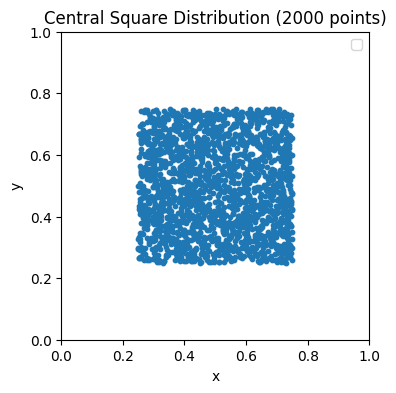

In [68]:
N_points = 2000 # From paper

np.random.seed(0)

x = np.random.uniform(low=0.25, high=0.75, size=N_points)
y = np.random.uniform(low=0.25, high=0.75, size=N_points)

# Plot the data
plt.figure(figsize=(4, 4))
plt.scatter(x, y, alpha=1, s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Central Square Distribution (2000 points)")
plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
plt.legend()
plt.show()

# Plot test data
def plot_xy(x_pts, y_pts):
    plt.figure(figsize=(4, 4))
    plt.scatter(x_pts, y_pts, alpha=1, s=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Test Generator Output")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.show()
    return plt.figure()

In [69]:
from torch.utils.data import Dataset, DataLoader

class XYDistribution(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.stack((self.x[idx], self.y[idx]))

In [70]:
def boundary_adherence(points, center=(0.5, 0.5), side_length=0.5):
    x_min, y_min = center[0] - side_length / 2, center[1] - side_length / 2
    x_max, y_max = center[0] + side_length / 2, center[1] + side_length / 2

    within_bounds = ((points[:, 0] >= x_min) & (points[:, 0] <= x_max) &
                     (points[:, 1] >= y_min) & (points[:, 1] <= y_max))
    adherence_rate = np.mean(within_bounds) * 100  # Convert to percentage
    return adherence_rate

### Training

In [71]:
noise_size = 3
code_size = 2
beta = 0.1

net_D = Discriminator(2, 86)
# compiled_D = torch.compile(net_D,mode='default')
compiled_D = net_D
net_G = Generator()
compiled_G = net_G
# compiled_G = torch.compile(net_G.forward,mode='default')
net_T = T(2, code_size, 80)
compiled_T = net_T
# compiled_T = torch.compile(net_T,mode='default')

batch_size = 80

dataset = XYDistribution(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size)

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = 2*torch.rand(1000, noise_size + code_size)-1

lrd = 0.0003
lrg = 0.001
lrt = 0.001
gamma_d = 0.85
gamma_g = 0.7
gamma_t = 0.7

optimizer_D = optim.Adam(compiled_D.parameters(), lr=lrd)
scheduler_D = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=gamma_d)
optimizer_G = optim.Adam(compiled_G.parameters(), lr=lrg)
scheduler_G = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=gamma_g)
optimizer_T = optim.Adam(compiled_T.parameters(), lr=lrt)
scheduler_T = optim.lr_scheduler.ExponentialLR(optimizer_D, gamma=gamma_t)

In [73]:
d_error = []
g_error = []
t_error = []
fk_prog = []
best_p_value = -99

wandb.init(
    project='InfoQGAN',
    config = {
        "Generator Architecture": str(dict(net_G.named_modules())),
        "Discriminator Architecture": str(dict(net_D.named_modules())),
        "T Architecture": str(dict(net_T.named_modules())),
        "Batch Size": batch_size
    }
)

for _ in range(300):
    for batch in dataloader:
        # First Update Discriminator with batch of Real Data
        d_loss = compiled_D.fit_discriminator(batch, criterion, compiled_G, optimizer_D, noise_size+code_size)
        g_loss = compiled_G.fit_generator(compiled_D, net_T, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)
        t_loss = compiled_T.fit_t(compiled_G, batch_size, noise_size+code_size, code_size, optimizer_T)

        # print("Batch done")
        d_error.append(d_loss)
        g_error.append(g_loss)
        t_error.append(t_loss)
        wandb.log({"d_loss": d_loss, "g_loss": g_loss, "t_loss": t_loss})
    
    print("Epoch: ", _)
    with torch.no_grad():
        fake = net_G(fixed_noise)
        # print(fake.size())
        acc = boundary_adherence(fake.detach().numpy())
        P, D = ndtest.ks2d2s(x, y, fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy(), extra=True)
        # if P > best_p_value:
        #     best_p_value = P
        #     torch.save(compiled_G.state_dict(), f'./models/run_72/pval{P}.pth')
        wandb.log({"Accuracy": acc, "KS Test p-value": P, "KS Test value": D})
        x_c1 = npreal.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 0])[0][1]
        x_c2 = npreal.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 1])[0][1]
        y_c1 = npreal.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 0])[0][1]
        y_c2 = npreal.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 1])[0][1]
        # print(x_c1)
        wandb.log({"Code 0 - X axis": x_c1, "Code 1 - X axis": x_c2, "Code 0 - Y axis": y_c1, "Code 1 - Y axis": y_c2})
        # print(P)

    if _ % 20 == 0:
        with torch.no_grad():
            fake = net_G(fixed_noise)
            clear_output(wait=True)
            fig = plot_xy(fake[:, 0].detach().numpy(), fake[:, 1].detach().numpy())
            # img = wandb.Image(fig)
            # wandb.log({"Generator Output": img})

wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


In [97]:
wandb.finish()

Accuracy,█▆▇▁▁▃▅▅▆▆▇▆▇▆▆▆▇▇▇▇▇▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇███▇
Code 0 - X axis,▁▃▅▇▇█████▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Code 0 - Y axis,█▃▂▁▄▅▅▆▅▆▆▅▄▄▄▄▃▂▃▅▃▄▂▂▁▂▃▃▄▃▄▃▂▂▂▂▂▁▂▂
Code 1 - X axis,▃█▅▃▃▃▂▁▁▁▁▁▃▃▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Code 1 - Y axis,▁▄▅██▇▆▆▆▆▆▆▆▆▇▇▆▆▆▆▆▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▆▆▇
KS Test p-value,▁▁▁▁▁▁▃▃▄▁▁█▂▂▂▁▁▃▁▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
KS Test value,█▆▄▃▃▂▁▁▁▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▃▂▂▃▂▃▂▂▂▂▃▂▂
d_loss,▆▆▆▇▆▅▆▇▆▆█▇▅▅▆▅▅▇▆▆▆▇▆▄▄▃▅▅▇▅▃▃▂▆▅▂▁▆▆▅
g_loss,█▇▆▆▄▃▄▄▅▄▅▅▄▅▄▃▃▃▄▁▄▂▄▃▂▁▂▂▃▄▄▄▄▄▃▄▄▄▂▃
t_loss,█▇▆▆▅▅▄▄▄▄▄▄▄▁▃▃▄▂▄▄▄▂▃▁▃▂▂▄▃▂▁▃▅▄▃▁▂▂▂▃
Accuracy,92.3


In [42]:
torch.save(compiled_G.state_dict(), './models/sage-dust-59.pth')

NameError: name 'compiled_G' is not defined

WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


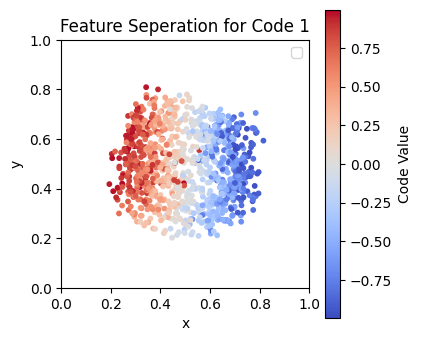

In [63]:
rand_inp = 2*torch.rand((1000, 5))-1
m = Generator()
m.load_state_dict(torch.load('./models/run_67/pval0.20862903252000067.pth'))

gen_output = m(rand_inp)

x_test = gen_output[:, 0].detach().numpy()
y_test = gen_output[:, 1].detach().numpy()

# Plot test data
def plot_xy_codes(x_pts, y_pts, code_index):
    plt.figure(figsize=(4, 4))
    plt.scatter(x_pts, y_pts, c=rand_inp[:, code_index], cmap='coolwarm', alpha=1, s=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Feature Seperation for Code {code_index}")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.colorbar(label='Code Value')
    plt.show()

plot_xy_codes(gen_output[:, 0].detach().numpy(), gen_output[:, 1].detach().numpy(), 1)

In [64]:
P, D = ndtest.ks2d2s(x, y, gen_output[:, 0].detach().numpy(), gen_output[:, 1].detach().numpy(), extra=True)

In [65]:
print(P, D)

0.19047759099344225 0.05125000000000002
